In [44]:
pwd

'/home/uniq/Documents/Deep Learning/VANILLA GAN'

In [45]:
#import packages
import torch
import torch.nn as nn

from torch import optim
from torch.utils.data import DataLoader

from torchvision.datasets import MNIST
from torchvision import transforms

from tqdm import tqdm

from matplotlib import pyplot as plt


In [46]:
#Hyper parameters
lr = 0.001
batch_size = 64
num_epochs = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Dataset Preparations

In [47]:
image_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Ensures input range is [-1, 1]
])


In [48]:
mnist_datasets = MNIST('./data',train=True, download=True, transform=image_transforms)

In [49]:
mnist_dataloader = DataLoader(mnist_datasets, batch_size=batch_size, shuffle=True, num_workers = 8, pin_memory=True)

In [50]:
next(iter(mnist_dataloader))[0].shape

torch.Size([64, 1, 28, 28])

# Model Building

In [51]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)
            

In [52]:
discriminator = Discriminator()
discriminator(torch.rand(10,784)).shape

torch.Size([10, 1])

In [53]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            # random noise 100 length
            nn.Linear(100, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh() #-1 to 1
        )
    def forward(self, x):
        return self.model(x)

In [54]:
generator = Generator()
generator(torch.randn(10,100)).shape

torch.Size([10, 784])

In [55]:
def noise(batch_size,device):
    return torch.randn(batch_size,100).to(device=device)

noise(64, 'cuda').shape

torch.Size([64, 100])

In [56]:

def visualize_samples(generator, device):
    # Generate noise and create fake samples
    samples = generator(noise(16, device)).view(-1, 28, 28).cpu().detach()

    # Create a grid for visualization
    grid = torch.cat([torch.cat([samples[i + j * 4] for i in range(4)], dim=1) for j in range(4)], dim=0)
    
    # Plot the grid
    plt.figure(figsize=(6, 6))
    plt.imshow(grid, cmap="gray")
    plt.axis("off")
    plt.show()


## Model Configurations

In [57]:
discriminator = Discriminator().to(device=device)
generator = Generator().to(device=device)
criteria = nn.BCELoss()
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0001) # gradient is calculated for all the parameters but it is updated only for the discriminator
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

In [58]:
def train_discriminator(discriminator, criteria, d_optimizer, real_image, fake_image, device):
    discriminator.train()
    d_optimizer.zero_grad()
    
    # Smooth labels for real and fake samples
    real_labels = torch.full((len(real_image), 1), 0.9, device=device)  # Smoothed real labels
    fake_labels = torch.full((len(fake_image), 1), 0.1, device=device)  # Smoothed fake labels

    # Forward pass for real images
    real_output = discriminator(real_image)
    real_loss = criteria(real_output, real_labels)

    # Forward pass for fake images
    fake_output = discriminator(fake_image)
    fake_loss = criteria(fake_output, fake_labels)

    # Combine losses
    total_loss = real_loss + fake_loss

    # Backpropagate and update discriminator weights
    total_loss.backward()
    d_optimizer.step()
    
    return total_loss


In [59]:
torch.zeros(64,1).shape

torch.Size([64, 1])

In [60]:
def train_generator(discriminator, criteria, g_optimizer, fake_image, device):
    g_optimizer.zero_grad()
    output = discriminator(fake_image)
    loss = criteria(output, torch.ones(len(output),1).to(device=device))  # generator should generate image that should be classified as 1 so torch.ones 
    loss.backward()

    g_optimizer.step()
    return loss

## Training loop

Train 1 of 100: 100%|██████████| 938/938 [00:09<00:00, 98.96it/s] 


Epoch 1/100
Generator Loss: 1865.8618, Discriminator Loss: 874.7043


Train 2 of 100: 100%|██████████| 938/938 [00:08<00:00, 109.25it/s]


Epoch 2/100
Generator Loss: 1508.2273, Discriminator Loss: 1012.5306


Train 3 of 100: 100%|██████████| 938/938 [00:08<00:00, 104.44it/s]


Epoch 3/100
Generator Loss: 1685.1831, Discriminator Loss: 878.6462


Train 4 of 100: 100%|██████████| 938/938 [00:09<00:00, 100.44it/s]


Epoch 4/100
Generator Loss: 1798.2062, Discriminator Loss: 848.3283


Train 5 of 100: 100%|██████████| 938/938 [00:09<00:00, 102.60it/s]


Epoch 5/100
Generator Loss: 1742.4543, Discriminator Loss: 864.8541


Train 6 of 100: 100%|██████████| 938/938 [00:09<00:00, 100.06it/s]


Epoch 6/100
Generator Loss: 1611.5158, Discriminator Loss: 892.0159


Train 7 of 100: 100%|██████████| 938/938 [00:09<00:00, 101.10it/s]


Epoch 7/100
Generator Loss: 1519.3586, Discriminator Loss: 932.0671


Train 8 of 100: 100%|██████████| 938/938 [00:09<00:00, 101.10it/s]


Epoch 8/100
Generator Loss: 1408.4564, Discriminator Loss: 963.0028


Train 9 of 100: 100%|██████████| 938/938 [00:09<00:00, 94.04it/s] 


Epoch 9/100
Generator Loss: 1294.0704, Discriminator Loss: 995.3452


Train 10 of 100: 100%|██████████| 938/938 [00:09<00:00, 98.37it/s] 


Epoch 10/100
Generator Loss: 1242.5051, Discriminator Loss: 1027.6432


Train 11 of 100: 100%|██████████| 938/938 [00:09<00:00, 99.09it/s] 


Epoch 11/100
Generator Loss: 1205.3668, Discriminator Loss: 1041.2265


Train 12 of 100: 100%|██████████| 938/938 [00:09<00:00, 94.99it/s] 


Epoch 12/100
Generator Loss: 1190.9612, Discriminator Loss: 1039.1202


Train 13 of 100: 100%|██████████| 938/938 [00:09<00:00, 94.08it/s] 


Epoch 13/100
Generator Loss: 1162.4720, Discriminator Loss: 1051.6523


Train 14 of 100: 100%|██████████| 938/938 [00:09<00:00, 96.13it/s] 


Epoch 14/100
Generator Loss: 1193.4376, Discriminator Loss: 1041.4209


Train 15 of 100: 100%|██████████| 938/938 [00:09<00:00, 101.97it/s]


Epoch 15/100
Generator Loss: 1127.4177, Discriminator Loss: 1072.8409


Train 16 of 100: 100%|██████████| 938/938 [00:08<00:00, 107.73it/s]


Epoch 16/100
Generator Loss: 1098.4590, Discriminator Loss: 1078.5305


Train 17 of 100: 100%|██████████| 938/938 [00:09<00:00, 104.15it/s]


Epoch 17/100
Generator Loss: 1080.9403, Discriminator Loss: 1088.6003


Train 18 of 100: 100%|██████████| 938/938 [00:09<00:00, 102.08it/s]


Epoch 18/100
Generator Loss: 1046.8921, Discriminator Loss: 1106.1648


Train 19 of 100: 100%|██████████| 938/938 [00:09<00:00, 103.78it/s]


Epoch 19/100
Generator Loss: 1028.1975, Discriminator Loss: 1109.9006


Train 20 of 100: 100%|██████████| 938/938 [00:09<00:00, 98.97it/s] 


Epoch 20/100
Generator Loss: 992.2043, Discriminator Loss: 1130.9777


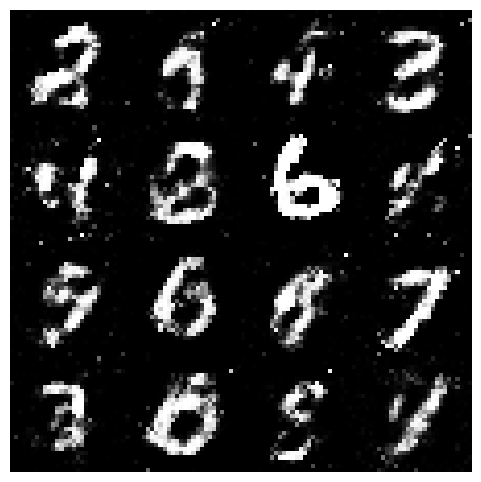

Train 21 of 100: 100%|██████████| 938/938 [00:09<00:00, 101.25it/s]


Epoch 21/100
Generator Loss: 980.9971, Discriminator Loss: 1136.2643


Train 22 of 100: 100%|██████████| 938/938 [00:09<00:00, 100.27it/s]


Epoch 22/100
Generator Loss: 960.2519, Discriminator Loss: 1145.1909


Train 23 of 100: 100%|██████████| 938/938 [00:09<00:00, 98.07it/s] 


Epoch 23/100
Generator Loss: 956.1064, Discriminator Loss: 1150.0370


Train 24 of 100: 100%|██████████| 938/938 [00:09<00:00, 98.52it/s] 


Epoch 24/100
Generator Loss: 945.1107, Discriminator Loss: 1153.0424


Train 25 of 100: 100%|██████████| 938/938 [00:09<00:00, 100.44it/s]


Epoch 25/100
Generator Loss: 938.8979, Discriminator Loss: 1156.2666


Train 26 of 100: 100%|██████████| 938/938 [00:09<00:00, 100.86it/s]


Epoch 26/100
Generator Loss: 933.3474, Discriminator Loss: 1156.8364


Train 27 of 100: 100%|██████████| 938/938 [00:09<00:00, 100.86it/s]


Epoch 27/100
Generator Loss: 920.9645, Discriminator Loss: 1162.7332


Train 28 of 100: 100%|██████████| 938/938 [00:09<00:00, 98.46it/s] 


Epoch 28/100
Generator Loss: 884.7252, Discriminator Loss: 1183.8267


Train 29 of 100: 100%|██████████| 938/938 [00:09<00:00, 104.20it/s]


Epoch 29/100
Generator Loss: 878.8791, Discriminator Loss: 1182.5385


Train 30 of 100: 100%|██████████| 938/938 [00:09<00:00, 100.96it/s]


Epoch 30/100
Generator Loss: 893.3573, Discriminator Loss: 1177.3228


Train 31 of 100: 100%|██████████| 938/938 [00:08<00:00, 111.75it/s]


Epoch 31/100
Generator Loss: 886.8822, Discriminator Loss: 1179.5844


Train 32 of 100: 100%|██████████| 938/938 [00:08<00:00, 105.15it/s]


Epoch 32/100
Generator Loss: 865.1703, Discriminator Loss: 1191.1224


Train 33 of 100: 100%|██████████| 938/938 [00:08<00:00, 110.37it/s]


Epoch 33/100
Generator Loss: 880.1108, Discriminator Loss: 1187.8032


Train 34 of 100: 100%|██████████| 938/938 [00:08<00:00, 106.99it/s]


Epoch 34/100
Generator Loss: 872.0875, Discriminator Loss: 1190.3930


Train 35 of 100: 100%|██████████| 938/938 [00:08<00:00, 107.27it/s]


Epoch 35/100
Generator Loss: 845.4119, Discriminator Loss: 1201.8999


Train 36 of 100: 100%|██████████| 938/938 [00:08<00:00, 111.05it/s]


Epoch 36/100
Generator Loss: 862.4900, Discriminator Loss: 1197.6785


Train 37 of 100: 100%|██████████| 938/938 [00:09<00:00, 100.54it/s]


Epoch 37/100
Generator Loss: 852.2390, Discriminator Loss: 1196.9253


Train 38 of 100: 100%|██████████| 938/938 [00:08<00:00, 104.52it/s]


Epoch 38/100
Generator Loss: 852.3437, Discriminator Loss: 1200.2718


Train 39 of 100: 100%|██████████| 938/938 [00:08<00:00, 112.10it/s]


Epoch 39/100
Generator Loss: 830.5400, Discriminator Loss: 1209.2716


Train 40 of 100: 100%|██████████| 938/938 [00:09<00:00, 100.61it/s]


Epoch 40/100
Generator Loss: 843.7659, Discriminator Loss: 1203.0501


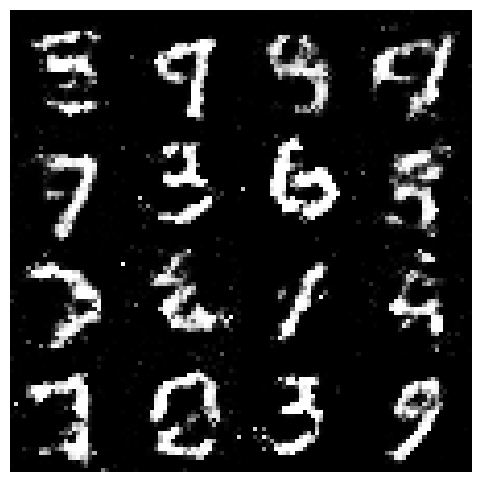

Train 41 of 100: 100%|██████████| 938/938 [00:08<00:00, 105.50it/s]


Epoch 41/100
Generator Loss: 845.0559, Discriminator Loss: 1202.8172


Train 42 of 100: 100%|██████████| 938/938 [00:08<00:00, 108.47it/s]


Epoch 42/100
Generator Loss: 827.3758, Discriminator Loss: 1210.5059


Train 43 of 100: 100%|██████████| 938/938 [00:08<00:00, 111.18it/s]


Epoch 43/100
Generator Loss: 835.2604, Discriminator Loss: 1208.6110


Train 44 of 100: 100%|██████████| 938/938 [00:08<00:00, 104.48it/s]


Epoch 44/100
Generator Loss: 826.5282, Discriminator Loss: 1212.7837


Train 45 of 100: 100%|██████████| 938/938 [00:09<00:00, 99.43it/s] 


Epoch 45/100
Generator Loss: 819.6272, Discriminator Loss: 1215.6248


Train 46 of 100: 100%|██████████| 938/938 [00:08<00:00, 115.08it/s]


Epoch 46/100
Generator Loss: 806.2384, Discriminator Loss: 1223.1506


Train 47 of 100: 100%|██████████| 938/938 [00:08<00:00, 114.21it/s]


Epoch 47/100
Generator Loss: 815.2496, Discriminator Loss: 1218.4701


Train 48 of 100: 100%|██████████| 938/938 [00:08<00:00, 108.41it/s]


Epoch 48/100
Generator Loss: 819.1523, Discriminator Loss: 1216.0953


Train 49 of 100: 100%|██████████| 938/938 [00:09<00:00, 99.42it/s] 


Epoch 49/100
Generator Loss: 802.7746, Discriminator Loss: 1223.5113


Train 50 of 100: 100%|██████████| 938/938 [00:09<00:00, 102.79it/s]


Epoch 50/100
Generator Loss: 805.7330, Discriminator Loss: 1223.7561


Train 51 of 100: 100%|██████████| 938/938 [00:09<00:00, 101.05it/s]


Epoch 51/100
Generator Loss: 817.1708, Discriminator Loss: 1216.6198


Train 52 of 100: 100%|██████████| 938/938 [00:09<00:00, 101.35it/s]


Epoch 52/100
Generator Loss: 812.8073, Discriminator Loss: 1217.0576


Train 53 of 100: 100%|██████████| 938/938 [00:08<00:00, 104.60it/s]


Epoch 53/100
Generator Loss: 806.3669, Discriminator Loss: 1222.9496


Train 54 of 100: 100%|██████████| 938/938 [00:08<00:00, 106.14it/s]


Epoch 54/100
Generator Loss: 800.7150, Discriminator Loss: 1227.7030


Train 55 of 100: 100%|██████████| 938/938 [00:09<00:00, 102.95it/s]


Epoch 55/100
Generator Loss: 785.4822, Discriminator Loss: 1231.5482


Train 56 of 100: 100%|██████████| 938/938 [00:08<00:00, 108.80it/s]


Epoch 56/100
Generator Loss: 801.4379, Discriminator Loss: 1223.9265


Train 57 of 100: 100%|██████████| 938/938 [00:08<00:00, 112.37it/s]


Epoch 57/100
Generator Loss: 803.3991, Discriminator Loss: 1225.4638


Train 58 of 100: 100%|██████████| 938/938 [00:08<00:00, 113.44it/s]


Epoch 58/100
Generator Loss: 794.4319, Discriminator Loss: 1228.3689


Train 59 of 100: 100%|██████████| 938/938 [00:08<00:00, 112.43it/s]


Epoch 59/100
Generator Loss: 795.9878, Discriminator Loss: 1227.6944


Train 60 of 100: 100%|██████████| 938/938 [00:08<00:00, 111.14it/s]


Epoch 60/100
Generator Loss: 794.8785, Discriminator Loss: 1228.7183


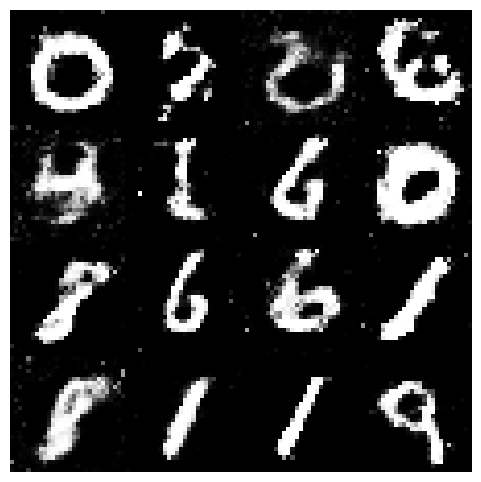

Train 61 of 100: 100%|██████████| 938/938 [00:08<00:00, 114.38it/s]


Epoch 61/100
Generator Loss: 791.9800, Discriminator Loss: 1229.7858


Train 62 of 100: 100%|██████████| 938/938 [00:08<00:00, 114.49it/s]


Epoch 62/100
Generator Loss: 789.7885, Discriminator Loss: 1233.3397


Train 63 of 100: 100%|██████████| 938/938 [00:08<00:00, 113.68it/s]


Epoch 63/100
Generator Loss: 795.5978, Discriminator Loss: 1226.5840


Train 64 of 100: 100%|██████████| 938/938 [00:08<00:00, 114.60it/s]


Epoch 64/100
Generator Loss: 797.6331, Discriminator Loss: 1228.0681


Train 65 of 100: 100%|██████████| 938/938 [00:08<00:00, 112.94it/s]


Epoch 65/100
Generator Loss: 791.0765, Discriminator Loss: 1228.5657


Train 66 of 100: 100%|██████████| 938/938 [00:08<00:00, 113.85it/s]


Epoch 66/100
Generator Loss: 792.9201, Discriminator Loss: 1231.3737


Train 67 of 100: 100%|██████████| 938/938 [00:08<00:00, 111.04it/s]


Epoch 67/100
Generator Loss: 789.6781, Discriminator Loss: 1231.9593


Train 68 of 100: 100%|██████████| 938/938 [00:08<00:00, 112.93it/s]


Epoch 68/100
Generator Loss: 786.7665, Discriminator Loss: 1231.6147


Train 69 of 100: 100%|██████████| 938/938 [00:08<00:00, 109.96it/s]


Epoch 69/100
Generator Loss: 780.1214, Discriminator Loss: 1234.6421


Train 70 of 100: 100%|██████████| 938/938 [00:08<00:00, 112.60it/s]


Epoch 70/100
Generator Loss: 777.2074, Discriminator Loss: 1236.7174


Train 71 of 100: 100%|██████████| 938/938 [00:08<00:00, 114.21it/s]


Epoch 71/100
Generator Loss: 787.2162, Discriminator Loss: 1232.1047


Train 72 of 100: 100%|██████████| 938/938 [00:08<00:00, 113.03it/s]


Epoch 72/100
Generator Loss: 779.4036, Discriminator Loss: 1237.6785


Train 73 of 100: 100%|██████████| 938/938 [00:08<00:00, 114.35it/s]


Epoch 73/100
Generator Loss: 779.9680, Discriminator Loss: 1235.7134


Train 74 of 100: 100%|██████████| 938/938 [00:08<00:00, 113.62it/s]


Epoch 74/100
Generator Loss: 772.1853, Discriminator Loss: 1240.1976


Train 75 of 100: 100%|██████████| 938/938 [00:08<00:00, 112.19it/s]


Epoch 75/100
Generator Loss: 772.4804, Discriminator Loss: 1239.9759


Train 76 of 100: 100%|██████████| 938/938 [00:08<00:00, 113.15it/s]


Epoch 76/100
Generator Loss: 773.4385, Discriminator Loss: 1239.2239


Train 77 of 100: 100%|██████████| 938/938 [00:08<00:00, 113.90it/s]


Epoch 77/100
Generator Loss: 771.0061, Discriminator Loss: 1240.1898


Train 78 of 100: 100%|██████████| 938/938 [00:08<00:00, 112.02it/s]


Epoch 78/100
Generator Loss: 772.8302, Discriminator Loss: 1240.1085


Train 79 of 100: 100%|██████████| 938/938 [00:08<00:00, 112.39it/s]


Epoch 79/100
Generator Loss: 775.2925, Discriminator Loss: 1239.8195


Train 80 of 100: 100%|██████████| 938/938 [00:08<00:00, 113.06it/s]


Epoch 80/100
Generator Loss: 767.9740, Discriminator Loss: 1241.1860


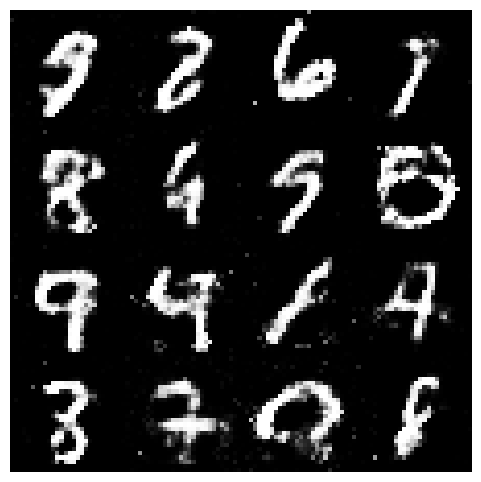

Train 81 of 100: 100%|██████████| 938/938 [00:08<00:00, 112.26it/s]


Epoch 81/100
Generator Loss: 765.2068, Discriminator Loss: 1241.6872


Train 82 of 100: 100%|██████████| 938/938 [00:08<00:00, 113.21it/s]


Epoch 82/100
Generator Loss: 766.1237, Discriminator Loss: 1242.9009


Train 83 of 100: 100%|██████████| 938/938 [00:08<00:00, 112.52it/s]


Epoch 83/100
Generator Loss: 768.3512, Discriminator Loss: 1242.6840


Train 84 of 100: 100%|██████████| 938/938 [00:08<00:00, 110.94it/s]


Epoch 84/100
Generator Loss: 762.3651, Discriminator Loss: 1244.4975


Train 85 of 100: 100%|██████████| 938/938 [00:08<00:00, 114.68it/s]


Epoch 85/100
Generator Loss: 760.2515, Discriminator Loss: 1246.1326


Train 86 of 100: 100%|██████████| 938/938 [00:08<00:00, 112.70it/s]


Epoch 86/100
Generator Loss: 759.5222, Discriminator Loss: 1245.3596


Train 87 of 100: 100%|██████████| 938/938 [00:08<00:00, 112.79it/s]


Epoch 87/100
Generator Loss: 758.0112, Discriminator Loss: 1248.7053


Train 88 of 100: 100%|██████████| 938/938 [00:08<00:00, 113.43it/s]


Epoch 88/100
Generator Loss: 763.3881, Discriminator Loss: 1247.0347


Train 89 of 100: 100%|██████████| 938/938 [00:08<00:00, 112.20it/s]


Epoch 89/100
Generator Loss: 761.7558, Discriminator Loss: 1244.9194


Train 90 of 100: 100%|██████████| 938/938 [00:08<00:00, 112.88it/s]


Epoch 90/100
Generator Loss: 764.8759, Discriminator Loss: 1243.8408


Train 91 of 100: 100%|██████████| 938/938 [00:08<00:00, 112.85it/s]


Epoch 91/100
Generator Loss: 759.9917, Discriminator Loss: 1246.7505


Train 92 of 100: 100%|██████████| 938/938 [00:08<00:00, 113.42it/s]


Epoch 92/100
Generator Loss: 759.7051, Discriminator Loss: 1249.3421


Train 93 of 100: 100%|██████████| 938/938 [00:08<00:00, 113.77it/s]


Epoch 93/100
Generator Loss: 760.2444, Discriminator Loss: 1245.2301


Train 94 of 100: 100%|██████████| 938/938 [00:08<00:00, 114.43it/s]


Epoch 94/100
Generator Loss: 755.1998, Discriminator Loss: 1248.0777


Train 95 of 100: 100%|██████████| 938/938 [00:08<00:00, 113.11it/s]


Epoch 95/100
Generator Loss: 755.4890, Discriminator Loss: 1250.2456


Train 96 of 100: 100%|██████████| 938/938 [00:08<00:00, 113.29it/s]


Epoch 96/100
Generator Loss: 757.0335, Discriminator Loss: 1249.2976


Train 97 of 100: 100%|██████████| 938/938 [00:08<00:00, 113.17it/s]


Epoch 97/100
Generator Loss: 756.0124, Discriminator Loss: 1247.6635


Train 98 of 100: 100%|██████████| 938/938 [00:08<00:00, 113.23it/s]


Epoch 98/100
Generator Loss: 754.8944, Discriminator Loss: 1250.0524


Train 99 of 100: 100%|██████████| 938/938 [00:08<00:00, 112.61it/s]


Epoch 99/100
Generator Loss: 758.2392, Discriminator Loss: 1248.2105


Train 100 of 100: 100%|██████████| 938/938 [00:08<00:00, 112.83it/s]

Epoch 100/100
Generator Loss: 757.3256, Discriminator Loss: 1248.4823


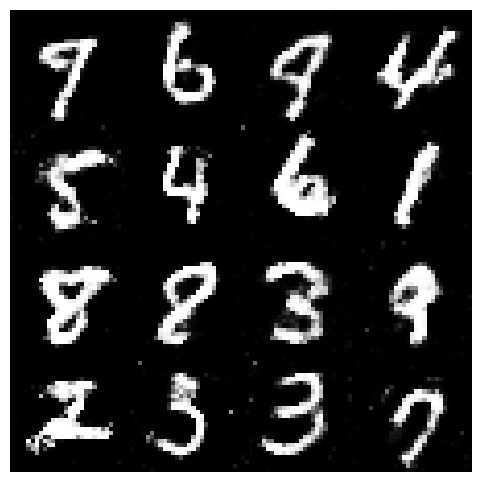

In [61]:
total_gen_loss, total_disc_loss = [], []

# Loop over epochs
for epoch in range(1, num_epochs + 1):
    epoch_gen_loss = 0
    epoch_disc_loss = 0

    # Loop over batches
    for images, _ in tqdm(mnist_dataloader, desc=f'Train {epoch} of {num_epochs}'):
        # Prepare real and fake images
        real_image = images.view(len(images), -1).to(device=device)
        fake_image = generator(noise(len(images), device=device))

        # Train the discriminator
        disc_loss = train_discriminator(discriminator, criteria, d_optimizer, real_image, fake_image, device)

        # Generate new fake images
        fake_image = generator(noise(len(images), device=device))

        # Train the generator
        gen_loss = train_generator(discriminator, criteria, g_optimizer, fake_image, device)

        # Accumulate losses for the epoch
        epoch_gen_loss += gen_loss.item()
        epoch_disc_loss += disc_loss.item()

    # Print epoch losses
    print(f"Epoch {epoch}/{num_epochs}")
    print(f"Generator Loss: {epoch_gen_loss:.4f}, Discriminator Loss: {epoch_disc_loss:.4f}")

    # Visualize generated samples
    if epoch %20  == 0:  # Visualize every epoch
        visualize_samples(generator, device)

    # Store losses for later visualization
    total_gen_loss.append(epoch_gen_loss)
    total_disc_loss.append(epoch_disc_loss)


In [62]:
# Save generator and discriminator models
torch.save(generator.state_dict(), 'generator1.pth')
torch.save(discriminator.state_dict(), 'discriminator2.pth')